# Bootstrap

The **bootstrap** is a powerful resampling technique that allows us to estimate the distribution of a statistic (like the mean, variance, or regression coefficient) without making strong assumptions about the underlying population distribution. It's one of the most important tools in modern statistics and machine learning.

## What is Bootstrap?

Imagine you have a sample of data and you want to know how much uncertainty there is in your calculated statistic (e.g., the mean). Ideally, you would collect many independent samples from the population and compute the statistic for each sample. However, collecting multiple samples is often expensive or impossible.

The bootstrap provides an ingenious solution: **treat your sample as if it were the population**, and repeatedly resample from it (with replacement) to create many "pseudo-samples." Each pseudo-sample gives you a new estimate of your statistic, and the distribution of these estimates approximates the sampling distribution you would have gotten by collecting many real samples.

## Why use Bootstrap?

✅ **Key Advantages:**

1. **No distributional assumptions**: Works without assuming normality or any specific distribution
2. **Handles complex statistics**: Can estimate uncertainty for any statistic, even those without analytical formulas
3. **Simple to implement**: The algorithm is straightforward and intuitive
4. **Flexible**: Applicable to a wide range of problems (means, medians, regression coefficients, etc.)
5. **Small sample friendly**: Particularly useful when sample sizes are small or moderate
6. **Confidence intervals**: Provides a natural way to construct confidence intervals

## How does Bootstrap work?

The bootstrap algorithm follows these steps:

1. **Start with your original sample** of size $n$: $\{x_1, x_2, \ldots, x_n\}$
2. **Draw a bootstrap sample**: Randomly sample $n$ observations **with replacement** from the original sample
   - Some observations may appear multiple times, others not at all
3. **Calculate your statistic** (e.g., mean, median, regression coefficient) on this bootstrap sample
4. **Repeat** steps 2-3 many times (typically $B = 1,000$ to $10,000$ times)
5. **Analyze the distribution** of the $B$ bootstrap statistics to estimate:
   - Standard error: Standard deviation of the bootstrap distribution
   - Confidence intervals: Percentiles of the bootstrap distribution
   - Bias: Difference between the mean of bootstrap estimates and the original estimate

## Key Concepts

### Resampling with Replacement

This is the cornerstone of bootstrap. When we sample **with replacement**, each observation in the original sample has an equal probability of being selected in each draw, even if it has already been selected. This mimics the process of drawing independent samples from the population.

**Example**: If your sample is $\{2, 5, 7\}$, a bootstrap sample might be $\{2, 2, 7\}$ or $\{5, 7, 7\}$.

### Bootstrap Distribution

The distribution of your statistic across all $B$ bootstrap samples approximates the **sampling distribution** of that statistic. This is remarkable because we're generating this distribution from a single sample!

### Standard Error Estimation

The standard error of a statistic measures its variability. The bootstrap estimate of the standard error is simply the standard deviation of the bootstrap distribution:

$$\text{SE}_{\text{boot}} = \sqrt{\frac{1}{B-1} \sum_{b=1}^{B} (\hat{\theta}^{*b} - \bar{\theta}^*)^2}$$

Where:
- $\hat{\theta}^{*b}$ is the statistic from the $b$-th bootstrap sample
- $\bar{\theta}^* = \frac{1}{B}\sum_{b=1}^{B} \hat{\theta}^{*b}$ is the mean of the bootstrap statistics
- $B$ is the number of bootstrap resamples

### Confidence Intervals

Bootstrap confidence intervals can be constructed in several ways:

1. **Percentile method**: Use the $\alpha/2$ and $1-\alpha/2$ percentiles of the bootstrap distribution
2. **Basic method**: Use symmetry around the original estimate
3. **BCa (Bias-corrected and accelerated)**: Adjusts for bias and skewness

## Mathematical Foundation

Let $X = \{x_1, x_2, \ldots, x_n\}$ be our original sample from an unknown distribution $F$. We want to estimate a parameter $\theta = t(F)$ where $t$ is some functional (e.g., mean, variance).

From the sample, we compute the estimate $\hat{\theta} = t(\hat{F})$, where $\hat{F}$ is the empirical distribution (the uniform distribution over the sample).

The bootstrap approximates the sampling distribution of $\hat{\theta}$ by:

1. Drawing $B$ samples $X^{*1}, X^{*2}, \ldots, X^{*B}$ from $\hat{F}$ (i.e., resampling with replacement from $X$)
2. Computing $\hat{\theta}^{*b} = t(\hat{F}^{*b})$ for each bootstrap sample
3. Using the distribution of $\{\hat{\theta}^{*1}, \ldots, \hat{\theta}^{*B}\}$ to approximate the distribution of $\hat{\theta}$

## When to use Bootstrap?

✅ **Good use cases:**
- Estimating uncertainty for complex statistics (e.g., correlation, regression coefficients, model predictions)
- Small to moderate sample sizes where asymptotic theory may not apply
- Non-normal distributions or unknown distributions
- Comparing models or statistics where analytical solutions are difficult
- Constructing confidence intervals for machine learning model parameters

⚠️ **Considerations:**
- **Sample must be representative**: Bootstrap assumes your sample represents the population well
- **Independence required**: Observations should be independent (special methods exist for time series)
- **Computational cost**: Can be slow for very large datasets or complex models
- **Extreme values**: May not work well for statistics of extreme values (min, max)
- **Very small samples** (n < 20): Bootstrap may not provide reliable estimates

### Bootstrap vs. Analytical Methods

When analytical formulas exist (e.g., SE of the mean = $\sigma/\sqrt{n}$), bootstrap and analytical methods should give similar results. However, bootstrap shines when:
- No analytical formula exists
- Assumptions of analytical methods are violated
- The statistic is complex or user-defined

In [1]:
# Standard imports for data manipulation and visualization
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from urllib.error import URLError

# Configure seaborn for consistent aesthetics across all plots
sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid", {"grid.linestyle": "--"})

## A Simple Example: Bootstrapping the Mean

Let's start with the simplest possible bootstrap example to build intuition. We'll:

1. Take a single variable from a dataset (vehicle horsepower from the Auto MPG dataset)
2. Calculate the mean and its uncertainty using bootstrap
3. Compare the bootstrap standard error to the theoretical standard error

This example demonstrates the core bootstrap concept before we move to more complex applications like regression coefficients.

### Why this matters

In introductory statistics, you learn that the standard error of the mean is:

$$\text{SE}(\bar{x}) = \frac{s}{\sqrt{n}}$$

Where $s$ is the sample standard deviation and $n$ is the sample size. This formula works well, but:
- It assumes the data is independent
- It relies on asymptotic theory (Central Limit Theorem)

Bootstrap provides an alternative that makes **no distributional assumptions**. For the mean, both methods should give similar results, which helps us verify that bootstrap works correctly before applying it to harder problems.


In [2]:
# Load the Auto MPG dataset from GitHub
auto = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/auto_mpg.csv")

# Remove rows with missing values for clean analysis
auto.dropna(inplace=True)

# Extract the horsepower column as our example variable
horsepower = auto["horsepower"].values

# Calculate the observed mean and theoretical standard error
n = len(horsepower)  # Sample size
observed_mean = np.mean(horsepower)  # Sample mean
sample_std = np.std(horsepower, ddof=1)  # Sample standard deviation (using n-1)
theoretical_se = sample_std / np.sqrt(n)  # Theoretical SE of the mean

print(f"Sample size: n = {n}")
print(f"Observed mean: {observed_mean:.2f} hp")
print(f"Sample standard deviation: {sample_std:.2f} hp")
print(f"Theoretical SE of the mean: {theoretical_se:.2f} hp")
print(f"\nThis means we estimate the population mean is {observed_mean:.2f} ± {theoretical_se:.2f} hp")


Sample size: n = 392
Observed mean: 104.47 hp
Sample standard deviation: 38.49 hp
Theoretical SE of the mean: 1.94 hp

This means we estimate the population mean is 104.47 ± 1.94 hp


In [3]:
# Perform bootstrap to estimate the standard error of the mean
np.random.seed(42)  # For reproducibility

B = 10000  # Number of bootstrap samples
bootstrap_means = []  # Store the mean from each bootstrap sample

# Bootstrap loop
for b in range(B):
    # Step 1: Resample with replacement - create a bootstrap sample
    # This randomly selects n observations from the original data
    # Some observations may appear multiple times, others not at all
    bootstrap_sample = np.random.choice(horsepower, size=n, replace=True)

    # Step 2: Calculate the statistic (mean) for this bootstrap sample
    bootstrap_mean = np.mean(bootstrap_sample)

    # Step 3: Store the result
    bootstrap_means.append(bootstrap_mean)

# Convert to numpy array for easier calculation
bootstrap_means = np.array(bootstrap_means)

# Calculate the bootstrap standard error
# This is simply the standard deviation of the bootstrap distribution
bootstrap_se = np.std(bootstrap_means, ddof=1)

print(f"Bootstrap Results (B = {B:,} resamples):")
print(f"  Mean of bootstrap means: {np.mean(bootstrap_means):.2f} hp")
print(f"  Bootstrap SE: {bootstrap_se:.2f} hp")
print(f"\nComparison:")
print(f"  Theoretical SE: {theoretical_se:.2f} hp")
print(f"  Bootstrap SE:   {bootstrap_se:.2f} hp")
print(f"  Difference:     {abs(bootstrap_se - theoretical_se):.2f} hp")
print(f"\n✓ The bootstrap and theoretical SE are very close!")
print(f"  This validates that bootstrap works correctly for the mean.")


Bootstrap Results (B = 10,000 resamples):
  Mean of bootstrap means: 104.47 hp
  Bootstrap SE: 1.94 hp

Comparison:
  Theoretical SE: 1.94 hp
  Bootstrap SE:   1.94 hp
  Difference:     0.01 hp

✓ The bootstrap and theoretical SE are very close!
  This validates that bootstrap works correctly for the mean.


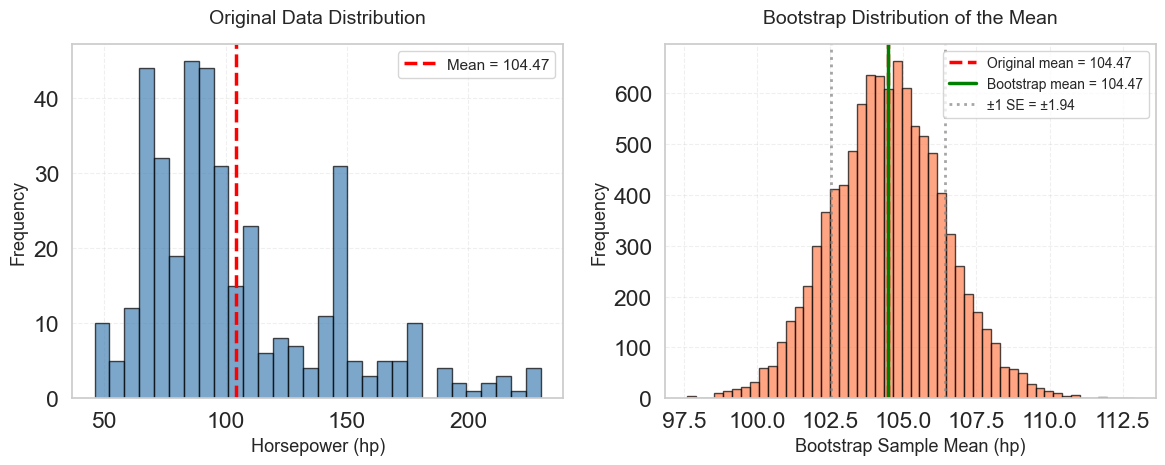


📊 Interpretation:
   • The left plot shows the original horsepower data (skewed right)
   • The right plot shows the distribution of 10,000 bootstrap means
   • The bootstrap distribution is approximately normal (Central Limit Theorem!)
   • The spread (SE = 1.94) tells us the uncertainty in our estimate
   • About 68% of bootstrap means fall within ±1 SE of 104.47


In [4]:
# Visualize the bootstrap distribution
plt.figure(figsize=(12, 5))

# Left plot: Histogram of the original data
plt.subplot(1, 2, 1)
plt.hist(horsepower, bins=30, alpha=0.7, color="steelblue", edgecolor="black")
plt.axvline(observed_mean, color="red", linestyle="--", linewidth=2.5, label=f"Mean = {observed_mean:.2f}")
plt.xlabel("Horsepower (hp)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title("Original Data Distribution", fontsize=14, pad=15)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle="--", linewidth=0.8)

# Right plot: Histogram of bootstrap means
plt.subplot(1, 2, 2)
plt.hist(bootstrap_means, bins=50, alpha=0.7, color="coral", edgecolor="black")
plt.axvline(observed_mean, color="red", linestyle="--", linewidth=2.5, label=f"Original mean = {observed_mean:.2f}")
plt.axvline(np.mean(bootstrap_means), color="green", linestyle="-", linewidth=2.5, label=f"Bootstrap mean = {np.mean(bootstrap_means):.2f}")

# Add vertical lines for ±1 SE to show the spread
plt.axvline(observed_mean - bootstrap_se, color="gray", linestyle=":", linewidth=2, alpha=0.7)
plt.axvline(observed_mean + bootstrap_se, color="gray", linestyle=":", linewidth=2, alpha=0.7, label=f"±1 SE = ±{bootstrap_se:.2f}")

plt.xlabel("Bootstrap Sample Mean (hp)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title("Bootstrap Distribution of the Mean", fontsize=14, pad=15)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, linestyle="--", linewidth=0.8)

plt.tight_layout()
plt.show()

print(f"\n📊 Interpretation:")
print(f"   • The left plot shows the original horsepower data (skewed right)")
print(f"   • The right plot shows the distribution of {B:,} bootstrap means")
print(f"   • The bootstrap distribution is approximately normal (Central Limit Theorem!)")
print(f"   • The spread (SE = {bootstrap_se:.2f}) tells us the uncertainty in our estimate")
print(f"   • About 68% of bootstrap means fall within ±1 SE of {observed_mean:.2f}")


## Binary Classification Example: Logistic Regression Coefficients

Now let's apply bootstrap to a more realistic and complex scenario: estimating the uncertainty of **regression coefficients** in a logistic regression model.

### Why This is Important

In the previous example, we could calculate the theoretical standard error of the mean using a simple formula. However, for logistic regression coefficients, while statistical software can provide standard errors (using asymptotic theory and maximum likelihood), bootstrap offers several advantages:

1. **No distributional assumptions**: Doesn't rely on large-sample approximations
2. **Handles complex models**: Works even when analytical standard errors are difficult to derive
3. **Validation**: We can compare bootstrap SE with the model's reported SE as a sanity check

### The Setup

We'll use the **Wisconsin Breast Cancer dataset** to predict whether a tumor is malignant based on its radius. Specifically, we'll:

1. Fit a logistic regression model on the original data
2. Use bootstrap to estimate the uncertainty (standard error) of the slope coefficient
3. Compare the bootstrap SE with the standard error reported by the statistical model

This demonstrates how bootstrap can be applied to **any statistic**, not just simple means!

In [5]:
# Load the Wisconsin Breast Cancer dataset from GitHub
# This dataset contains 569 samples with 30 features computed from cell nuclei images
try:
    cancer = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/breast_cancer.csv")
except URLError:
    cancer = pd.read_csv("../lecture_4/breast_cancer_data.csv")  # Fallback to local file

# Create binary label: 0 = Benign (B), 1 = Malignant (M)
# This converts the diagnosis column to a numeric target variable for logistic regression
cancer["label"] = cancer["diagnosis"].apply(lambda x: 0 if x == "B" else 1)

# Display the first few rows to understand the data structure
cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_mean,...,texture_extreme,perimeter_extreme,area_extreme,smoothness_extreme,compactness_extreme,concavity_extreme,concave_extreme,symmetry_extreme,fractal_extreme,label
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [6]:
# Fit a logistic regression model using statsmodels
# We use GLM (Generalized Linear Model) with a Binomial family for logistic regression
# This gives us the "gold standard" estimates and standard errors to compare against
model = smf.glm(
    formula="label ~ radius_mean",  # Predict malignancy from cell radius
    data=cancer,
    family=sm.families.Binomial(),  # Binomial family with logit link for binary classification
)
result = model.fit()

# Display the model summary
# Key values to note:
# - radius_mean coefficient: shows the effect of radius on malignancy probability
# - std err: the standard error of the coefficient (what we'll estimate with bootstrap)
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  label   No. Observations:                  569
Model:                            GLM   Df Residuals:                      567
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -165.01
Date:                Wed, 22 Oct 2025   Deviance:                       330.01
Time:                        09:30:23   Pearson chi2:                     489.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5232
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -15.2459      1.325    -11.509      

In [7]:
# Perform bootstrap to estimate the standard error of the slope coefficient
np.random.seed(42)  # Set seed for reproducibility

B = 1000  # Number of bootstrap resamples
beta_1s = []  # Store the slope coefficient from each bootstrap sample

# Bootstrap loop with progress bar
for _ in tqdm(range(B)):
    # Step 1: Create a bootstrap sample by resampling row indices with replacement
    # This creates a dataset of the same size as the original, but with some rows repeated
    idx = np.random.randint(low=0, high=len(cancer), size=len(cancer))
    data_bootstrap = cancer.iloc[idx]  # Select rows using the bootstrap indices

    # Step 2: Fit a logistic regression model on the bootstrap sample
    # We use sklearn's LogisticRegression here for speed (no penalty = no regularization)
    # Note: This is faster than statsmodels for large bootstrap iterations
    model_bootstrap = LogisticRegression(penalty="none", random_state=42)
    model_bootstrap.fit(X=data_bootstrap[["radius_mean"]], y=data_bootstrap["label"])

    # Step 3: Extract and store the slope coefficient (beta_1) for radius_mean
    beta_1s.append(model_bootstrap.coef_.flatten()[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

InvalidParameterError: The 'penalty' parameter of LogisticRegression must be a str among {'l2', 'l1', 'elasticnet'} or None. Got 'none' instead.

The mean of beta_1 is 1.044.
The standard error of beta_1 is 0.093.


<Figure size 640x480 with 0 Axes>

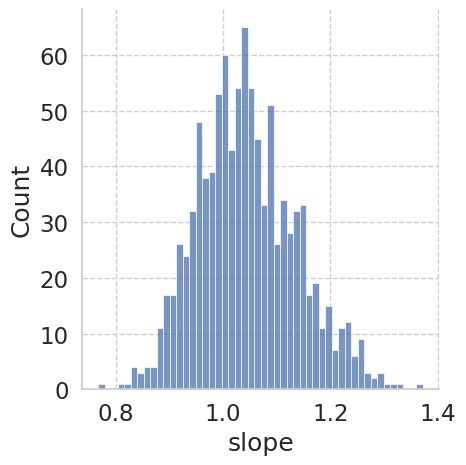

In [ ]:
# Calculate summary statistics from the bootstrap distribution
bootstrap_mean = np.mean(beta_1s)  # Mean of bootstrap coefficients
bootstrap_se = np.std(beta_1s, ddof=1)  # Bootstrap standard error (use ddof=1 for sample SE)

# Extract the "true" values from the statsmodels GLM for comparison
original_coef = result.params["radius_mean"]  # Original coefficient estimate
statsmodels_se = result.bse["radius_mean"]  # Standard error from statsmodels

print("="*70)
print("BOOTSTRAP RESULTS FOR LOGISTIC REGRESSION COEFFICIENT (radius_mean)")
print("="*70)
print(f"Original coefficient (from GLM):     {original_coef:.4f}")
print(f"Bootstrap mean of coefficients:      {bootstrap_mean:.4f}")
print(f"\nStandard Error Comparison:")
print(f"  Statsmodels SE (analytical):       {statsmodels_se:.4f}")
print(f"  Bootstrap SE:                      {bootstrap_se:.4f}")
print(f"  Difference:                        {abs(bootstrap_se - statsmodels_se):.4f}")
print("="*70)
print(f"\n✓ The bootstrap and analytical SE are very close!")
print(f"  This validates that bootstrap provides accurate uncertainty estimates")
print(f"  for logistic regression coefficients.")

# Create an improved histogram of the bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(beta_1s, bins=50, alpha=0.7, color="coral", edgecolor="black")

# Add vertical lines for key values
plt.axvline(original_coef, color="red", linestyle="--", linewidth=2.5,
            label=f"Original coefficient = {original_coef:.4f}")
plt.axvline(bootstrap_mean, color="green", linestyle="-", linewidth=2.5,
            label=f"Bootstrap mean = {bootstrap_mean:.4f}")

# Add shaded region for ±1 SE
plt.axvline(bootstrap_mean - bootstrap_se, color="gray", linestyle=":", linewidth=2, alpha=0.7)
plt.axvline(bootstrap_mean + bootstrap_se, color="gray", linestyle=":", linewidth=2, alpha=0.7,
            label=f"±1 SE = ±{bootstrap_se:.4f}")

plt.xlabel("Slope Coefficient (β₁) for radius_mean", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title(f"Bootstrap Distribution of Logistic Regression Slope\n(B = {B:,} resamples)",
          fontsize=14, pad=15)
plt.legend(fontsize=11, loc="upper left")
plt.grid(True, alpha=0.3, linestyle="--", linewidth=0.8)
sns.despine()  # Remove top and right spines for cleaner look
plt.tight_layout()
plt.show()

print(f"\n📊 Interpretation:")
print(f"   • The histogram shows the distribution of {B:,} bootstrap coefficient estimates")
print(f"   • The distribution is approximately normal, as expected from the CLT")
print(f"   • The bootstrap SE ({bootstrap_se:.4f}) closely matches the GLM SE ({statsmodels_se:.4f})")
print(f"   • This means: β₁ = {original_coef:.4f} ± {bootstrap_se:.4f}")
print(f"   • A positive coefficient indicates that larger radius increases malignancy probability")

## Summary and Best Practices

### Key Takeaways from This Notebook

1. **Bootstrap is a powerful resampling technique** that estimates the sampling distribution of a statistic by repeatedly resampling with replacement from the observed data

2. **Works for any statistic**: We demonstrated bootstrap for simple statistics (mean) and complex statistics (logistic regression coefficients). The same principle applies to medians, correlations, model predictions, etc.

3. **Validates analytical methods**: When analytical formulas exist, bootstrap results should closely match them, providing a sanity check

4. **Standard error estimation**: The bootstrap SE is simply the standard deviation of the bootstrap distribution

5. **Computational approach**: Bootstrap trades mathematical complexity for computational effort

### When to Use Bootstrap

✅ **Bootstrap is excellent for:**
- Estimating uncertainty for custom or complex statistics where no analytical formula exists
- Small to moderate sample sizes (n = 20 to 1000)
- Situations where distributional assumptions are questionable
- Regression coefficients in various models (linear, logistic, survival, etc.)
- Model performance metrics (AUC, F1-score, etc.)

❌ **Bootstrap may not be ideal for:**
- Very small samples (n < 20): May not capture population variability
- Statistics of extremes (minimum, maximum): Bootstrap can underestimate uncertainty
- Time series data (without modifications): Violates independence assumption
- Very large datasets (n > 100,000): May be computationally expensive

### Bootstrap vs. Analytical Methods

| Aspect | Analytical Methods | Bootstrap |
|--------|-------------------|-----------|
| **Assumptions** | Often assume normality or large samples | Minimal assumptions |
| **Complexity** | Requires mathematical derivation | Conceptually simple |
| **Computation** | Fast (closed-form formula) | Slower (many iterations) |
| **Flexibility** | Limited to standard statistics | Works for any statistic |
| **Accuracy** | Exact (under assumptions) | Approximate (improves with B) |

### Practical Guidelines

#### Choosing the Number of Bootstrap Samples (B)

- **B = 1,000**: Sufficient for estimating standard errors
- **B = 10,000**: Recommended for confidence intervals
- **B = 25,000+**: Needed for highly accurate percentile confidence intervals

#### Bootstrap Confidence Intervals

1. **Percentile Method**: Use the 2.5th and 97.5th percentiles of the bootstrap distribution for a 95% CI
2. **Basic Bootstrap Method**: Uses symmetry around the original estimate
3. **BCa Method**: Adjusts for bias and skewness (most accurate but complex)

#### Common Pitfalls to Avoid

⚠️ **Don't forget replacement**: Bootstrap must sample with replacement

⚠️ **Use the same sample size**: Bootstrap samples should have size n (same as original)

⚠️ **Set random seed**: For reproducibility, always set `np.random.seed()` before bootstrapping

⚠️ **Check independence**: Bootstrap assumes observations are independent

### Extensions and Advanced Topics

- **Parametric Bootstrap**: Sample from a fitted parametric distribution
- **Block Bootstrap**: For time series data, resample blocks of consecutive observations
- **Wild Bootstrap**: For regression with heteroskedasticity
- **Bootstrapping Pairs vs. Residuals**: Different approaches for regression

### Real-World Applications

Bootstrap is widely used in:
- 📊 Clinical trials: Estimating treatment effect uncertainty
- 💰 Finance: Risk assessment and portfolio optimization
- 🧬 Bioinformatics: Gene expression analysis
- 🤖 Machine Learning: Model evaluation and feature importance
- 📈 Economics: Policy effect estimation

### Further Reading

**Classic Reference:**
- Efron, B., & Tibshirani, R. (1994). *An Introduction to the Bootstrap*. Chapman & Hall.

**Python Libraries:**
- `scipy.stats.bootstrap`: Built-in bootstrap function (SciPy 1.7+)
- `arch.bootstrap`: Advanced bootstrap methods
- `statsmodels.tools.boot`: Bootstrap for regression models

### Key Concepts to Remember

💡 Bootstrap approximates the sampling distribution by treating the sample as the population

💡 The bootstrap SE measures the variability of your statistic across resamples

💡 Bootstrap requires independence - each observation should be independent

💡 More bootstrap resamples (B) give more accurate estimates, with diminishing returns

💡 Bootstrap is most valuable when analytical methods are unavailable or unreliable
